# Langton's Ants

In [1]:
# Try installing MoviePy with the command:
# conda install -c conda-forge moviepy
from langton import *
%matplotlib notebook

[MoviePy] >>>> Building video open.mp4
[MoviePy] Writing video open.mp4


100%|█████████▉| 12000/12001 [07:37<00:00, 13.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: open.mp4 



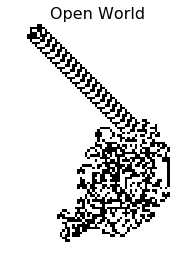

In [15]:
ow = OpenWorld()
ow.add_ant((0,0), right)
ow.ani_gen('open.mp4', 'Open World', duration = 240)

[MoviePy] >>>> Building video fixed.mp4
[MoviePy] Writing video fixed.mp4


100%|█████████▉| 12000/12001 [08:02<00:00, 24.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: fixed.mp4 



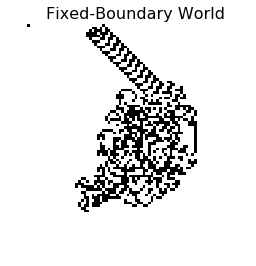

In [16]:
fbw = ClosedWorld(81,81,'fixed')
fbw.add_ant((40,40), right)
fbw.ani_gen('fixed.mp4', 'Fixed-Boundary World', duration = 240)

[MoviePy] >>>> Building video wrapped.mp4
[MoviePy] Writing video wrapped.mp4


100%|█████████▉| 30000/30001 [20:55<00:00, 23.89it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: wrapped.mp4 



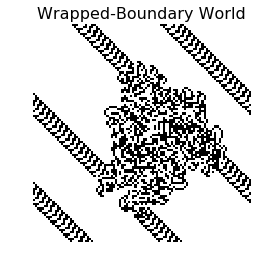

In [17]:
wbw = ClosedWorld(101,101)
wbw.add_ant((50,50), right)
wbw.ani_gen('wrapped.mp4', 'Wrapped-Boundary World', duration = 6e2)

[MoviePy] >>>> Building video RRLL.mp4
[MoviePy] Writing video RRLL.mp4


100%|█████████▉| 15000/15001 [09:52<00:00, 25.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: RRLL.mp4 



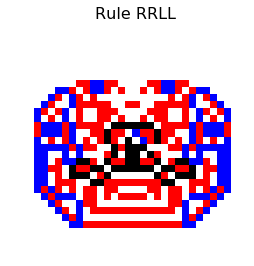

In [22]:
rrll = ClosedWorld(31,31)
rrll.add_ant((15,15), right, RRLL)
rrll.ani_gen('RRLL.mp4', 'Rule RRLL', quadcmap)

[MoviePy] >>>> Building video RLLL.mp4
[MoviePy] Writing video RLLL.mp4



  3%|▎         | 443/15001 [00:20<09:14, 26.27it/s]


  6%|▌         | 915/15001 [00:41<09:43, 24.16it/s]


  9%|▉         | 1380/15001 [01:00<08:55, 25.43it/s]


 12%|█▏        | 1842/15001 [01:18<09:19, 23.51it/s]


 15%|█▌        | 2304/15001 [01:37<08:02, 26.34it/s]


 18%|█▊        | 2766/15001 [01:55<08:08, 25.06it/s]


 22%|██▏       | 3228/15001 [02:14<08:51, 22.16it/s]


 24%|██▍       | 3626/15001 [02:37<11:10, 16.96it/s]


 27%|██▋       | 4015/15001 [02:57<08:55, 20.52it/s]


 29%|██▉       | 4390/15001 [03:17<07:30, 23.54it/s]


 32%|███▏      | 4815/15001 [03:38<07:05, 23.93it/s]


 35%|███▌      | 5270/15001 [03:58<08:13, 19.70it/s]


 38%|███▊      | 5732/15001 [04:18<06:31, 23.69it/s]


 41%|████      | 6156/15001 [04:39<07:56, 18.55it/s]


 44%|████▍     | 6602/15001 [04:59<06:15, 22.36it/s]


 47%|████▋     | 7064/15001 [05:20<05:52, 22.53it/s]


 50%|█████     | 7516/15001 [05:40<05:26, 22.95it/s]


 53%|█████▎    | 7911/15001 [06:03<05:11, 22.77it/s]


 55%|█████▌    | 8271/15001 [06:25<05:33, 20.16it/s]


 58%|█████▊    | 8660/15001 [06:47<06:31, 16.19it/s]


 60%|██████    | 9070/15001 [07:07<04:24, 22.45it/s]


 63%|██████▎   | 9485/15001 [07:29<04:08, 22.21it/s]


 66%|██████▌   | 9851/15001 [07:54<03:59, 21.51it/s]


 69%|██████▊   | 10296/15001 [08:15<03:20, 23.47it/s]


 71%|███████   | 10661/15001 [08:37<04:48, 15.03it/s]


 73%|███████▎  | 11011/15001 [08:56<03:39, 18.16it/s]


 76%|███████▌  | 11408/15001 [09:16<02:43, 21.93it/s]


 78%|███████▊  | 11760/15001 [09:40<03:53, 13.87it/s]


 81%|████████  | 12143/15001 [10:01<02:57, 16.11it/s]


 84%|████████▍ | 12574/15001 [10:22<02:01, 20.06it/s]


 86%|████████▌ | 12911/15001 [10:41<01:53, 18.41it/s]


 89%|████████▊ | 13301/15001 [11:01<01:28, 19.21it/s]


 91%|█████████ | 13653/15001 [11:23<01:07, 20.05it/s]


 93%|█████████▎| 14002/15001 [11:43<00:56, 17.71it/s]


 95%|█████████▌| 14307/15001 [12:06<03:49,  3.02it/s]


 97%|█████████▋| 14620/15001 [12:35<00:24, 15.30it/s]


100%|█████████▉| 14929/15001 [12:57<00:04, 14.54it/s]


100%|█████████▉| 15000/15001 [13:01<00:00, 16.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: RLLL.mp4 



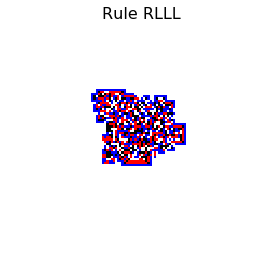

In [30]:
rlll = ClosedWorld(101,101)
rlll.add_ant((50,50), right, RLLL)
rlll.ani_gen('RLLL.mp4', 'Rule RLLL', quadcmap)

[MoviePy] >>>> Building video RLRL.mp4
[MoviePy] Writing video RLRL.mp4



  3%|▎         | 424/15001 [00:21<12:35, 19.30it/s]


  6%|▌         | 896/15001 [00:40<09:30, 24.74it/s]


  9%|▊         | 1294/15001 [01:06<18:08, 12.59it/s]


 11%|█         | 1675/15001 [01:31<13:07, 16.92it/s]


 14%|█▍        | 2100/15001 [01:54<10:46, 19.94it/s]


 17%|█▋        | 2548/15001 [02:14<10:11, 20.38it/s]


 20%|██        | 3010/15001 [02:34<08:00, 24.93it/s]


 23%|██▎       | 3472/15001 [02:53<07:29, 25.66it/s]


 26%|██▌       | 3934/15001 [03:12<07:44, 23.82it/s]


 29%|██▉       | 4387/15001 [03:33<08:22, 21.13it/s]


 32%|███▏      | 4849/15001 [03:52<06:54, 24.50it/s]


 35%|███▌      | 5311/15001 [04:11<06:44, 23.93it/s]


 38%|███▊      | 5769/15001 [04:31<08:10, 18.82it/s]


 42%|████▏     | 6231/15001 [04:51<06:19, 23.12it/s]


 45%|████▍     | 6693/15001 [05:10<05:51, 23.65it/s]


 47%|████▋     | 7112/15001 [05:32<06:08, 21.41it/s]


 50%|█████     | 7569/15001 [05:53<05:31, 22.39it/s]


 54%|█████▎    | 8028/15001 [06:13<06:11, 18.79it/s]


 57%|█████▋    | 8485/15001 [06:33<04:31, 23.97it/s]


 59%|█████▉    | 8924/15001 [06:54<04:24, 22.99it/s]


 63%|██████▎   | 9378/15001 [07:15<04:39, 20.11it/s]


 65%|██████▌   | 9811/15001 [07:36<04:16, 20.26it/s]


 68%|██████▊   | 10262/15001 [07:57<03:39, 21.57it/s]


 71%|███████▏  | 10711/15001 [08:17<03:01, 23.67it/s]


 74%|███████▍  | 11142/15001 [08:37<03:24, 18.87it/s]


 77%|███████▋  | 11553/15001 [08:58<03:06, 18.48it/s]


 79%|███████▉  | 11869/15001 [09:16<03:04, 17.02it/s]


 82%|████████▏ | 12228/15001 [09:38<02:41, 17.16it/s]


 84%|████████▍ | 12649/15001 [09:57<01:59, 19.71it/s]


 87%|████████▋ | 13086/15001 [10:18<01:28, 21.55it/s]


 90%|█████████ | 13530/15001 [10:38<01:11, 20.64it/s]


 93%|█████████▎| 13983/15001 [11:00<00:48, 20.95it/s]


 96%|█████████▌| 14389/15001 [11:21<01:52,  5.42it/s]


 98%|█████████▊| 14744/15001 [11:47<00:12, 20.36it/s]


100%|█████████▉| 15000/15001 [11:59<00:00, 20.85it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: RLRL.mp4 



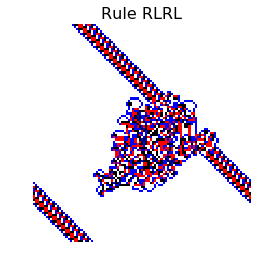

In [31]:
rlrl = ClosedWorld(101,101)
rlrl.add_ant((50,50), right, RLRL)
rlrl.ani_gen('RLRL.mp4', 'Rule RLRL', quadcmap)

[MoviePy] >>>> Building video double.mp4
[MoviePy] Writing video double.mp4


100%|█████████▉| 15000/15001 [09:53<00:00, 25.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: double.mp4 



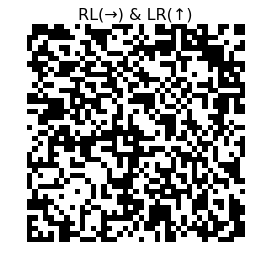

In [20]:
double = ClosedWorld(41,41)
double.add_ant((20,20), right)
double.add_ant((20,20), up, LR)
double.ani_gen('double.mp4', 'RL(→) & LR(↑)')

[MoviePy] >>>> Building video double2.mp4
[MoviePy] Writing video double2.mp4


100%|█████████▉| 15000/15001 [10:27<00:00, 23.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: double2.mp4 



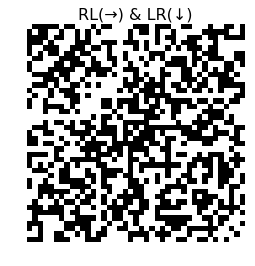

In [21]:
double2 = ClosedWorld(41,41)
double2.add_ant((20,20), right)
double2.add_ant((20,20), down, LR)
double2.ani_gen('double2.mp4', 'RL(→) & LR(↓)')